<a href="https://colab.research.google.com/github/Babyaimy/sentimentanalysis-airbnb-london/blob/main/DistilBERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RQ2: How do sentiment trends vary over time, particularly during significant events such as economic crisis (e.g., Brexit in UK) and COVID-19 pandemic, and are there notable differences in sentiment expressions during those specific phases?**

In [1]:
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 30.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
# Load the dataset
file_path = 'spelling_corrected_reviews.csv'  # Replace with your actual file path
reviews_df = pd.read_csv(file_path)

reviews_df

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,49970,160176,2010-12-29,160135,guest_001,great value room shared bathroom but i never s...,en
1,49970,192563,2011-03-05,369665,guest_002,bores was very helpful and forthcoming the roo...,en
2,49970,195499,2011-03-09,403879,guest_003,bores is very very helpful we would definitely...,en
3,49970,202101,2011-03-18,378633,guest_004,the viva rooms are great and i would recommend...,en
4,49970,204622,2011-03-21,374240,guest_005,it was a very great experience bores himself w...,en
...,...,...,...,...,...,...,...
33164,1081167718843974592,1112284612757040368,2024-03-14,142450328,guest_33165,really nice place and close to the train stati...,en
33165,1100660077859283147,1109412401646643280,2024-03-10,266554673,guest_33166,well located easy access online checkout clean...,en
33166,1105743233541646659,1115106341549734275,2024-03-18,105137442,guest_33167,we had great fun at this house great access to...,en
33167,1105743233541646659,1115862902049030293,2024-03-19,558328375,guest_33168,clean quality accommodation in the city center...,en


In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = 'spelling_corrected_reviews.csv'  # Replace with your actual file path
reviews_df = pd.read_csv(file_path)

# Preprocess the review text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

reviews_df['comments'] = reviews_df['comments'].apply(preprocess_text)

# Apply VADER sentiment analysis for initial labeling
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Check VADER sentiment scores
reviews_df['sentiment_scores'] = reviews_df['comments'].apply(lambda x: sid.polarity_scores(x))
reviews_df['sentiment_score'] = reviews_df['sentiment_scores'].apply(lambda x: x['compound'])
reviews_df['sentiment'] = reviews_df['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

# Log sentiment distribution
print("Sentiment distribution after VADER analysis:")
print(reviews_df['sentiment'].value_counts())

# Display some samples with their scores and assigned sentiment
print(reviews_df[['comments', 'sentiment_scores', 'sentiment']].head(10))


KeyboardInterrupt: 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment distribution after VADER analysis:
sentiment
positive    30985
negative     1388
neutral       796
Name: count, dtype: int64
                                            comments  \
0  great value room shared bathroom but i never s...   
1  bores was very helpful and forthcoming the roo...   
2  bores is very very helpful we would definitely...   
3  the viva rooms are great and i would recommend...   
4  it was a very great experience bores himself w...   
5  fantasticbook with bores with full confidenceb...   
6  small but extremely comfortable studio all the...   
7  conveniently located the tube is a  minute wal...   
8  the studio was just as described it has everyt...   
9  i stayed in viva  bores does an amazing job ke...   

                                    sentiment_scores sentiment  
0  {'neg': 0.079, 'neu': 0.509, 'pos': 0.412, 'co...  positive  
1  {'neg': 0.1, 'neu': 0.61, 'pos': 0.29, 'compou...  positive  
2  {'neg': 0.132, 'neu': 0.518, 'pos': 0.35, 'com... 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss
1,0.085600,0.092908
2,0.095200,0.089269
3,0.011800,0.093703


Starting evaluation...


{'eval_loss': 0.08926939219236374, 'eval_runtime': 23.2655, 'eval_samples_per_second': 285.144, 'eval_steps_per_second': 4.47, 'epoch': 3.0}
Predicted sentiment distribution after model prediction:
predicted_sentiment
positive    30792
negative     1725
neutral       652
Name: count, dtype: int64
predicted_sentiment  negative   neutral  positive
date                                             
2010-12              0.000000  0.000000  1.000000
2011-03              0.000000  0.000000  1.000000
2011-04              0.000000  0.000000  1.000000
2011-05              0.000000  0.000000  1.000000
2011-06              0.000000  0.000000  1.000000
...                       ...       ...       ...
2023-11              0.048305  0.019492  0.932203
2023-12              0.041270  0.015079  0.943651
2024-01              0.057201  0.021450  0.921348
2024-02              0.051387  0.024666  0.923947
2024-03              0.037333  0.021333  0.941333

[144 rows x 3 columns]


<Figure size 1200x600 with 0 Axes>

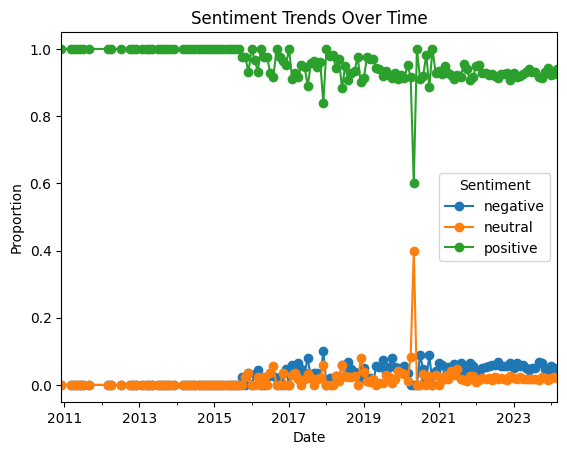

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = 'spelling_corrected_reviews.csv'  # Replace with your actual file path
reviews_df = pd.read_csv(file_path)

# Preprocess the review text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

reviews_df['comments'] = reviews_df['comments'].apply(preprocess_text)

# Apply VADER sentiment analysis for initial labeling
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Check VADER sentiment scores
reviews_df['sentiment_scores'] = reviews_df['comments'].apply(lambda x: sid.polarity_scores(x))
reviews_df['sentiment_score'] = reviews_df['sentiment_scores'].apply(lambda x: x['compound'])
reviews_df['sentiment'] = reviews_df['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

# Log sentiment distribution
print("Sentiment distribution after VADER analysis:")
print(reviews_df['sentiment'].value_counts())

# Display some samples with their scores and assigned sentiment
print(reviews_df[['comments', 'sentiment_scores', 'sentiment']].head(10))

# Encode sentiment labels
label_encoder = LabelEncoder()
reviews_df['label'] = label_encoder.fit_transform(reviews_df['sentiment'])

# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(reviews_df['comments'], reviews_df['label'], test_size=0.2, random_state=42)

# Reset indices to ensure they are continuous
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Tokenize the text data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class ReviewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Convert labels to Long type
        return item

    def __len__(self):
        return len(self.labels)

# Create train and validation datasets
train_dataset = ReviewsDataset(train_texts, train_labels)
val_dataset = ReviewsDataset(val_texts, val_labels)

# Load pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Evaluate every epoch
    save_strategy="epoch",           # Save every epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
)

# Define Trainer with logging
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

# Train the model with additional logging
print("Starting training...")
trainer.train()

# Evaluate the model
print("Starting evaluation...")
eval_result = trainer.evaluate()
print(eval_result)

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_distilbert')
tokenizer.save_pretrained('./fine_tuned_distilbert')

# Apply the fine-tuned model for sentiment prediction
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return label_encoder.inverse_transform([prediction])[0]

reviews_df['predicted_sentiment'] = reviews_df['comments'].apply(predict_sentiment)

# Log predicted sentiment distribution
print("Predicted sentiment distribution after model prediction:")
print(reviews_df['predicted_sentiment'].value_counts())

# Sentiment Trends Analysis
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

# Calculate the proportion of each sentiment category by date
sentiment_proportions = reviews_df.groupby(reviews_df['date'].dt.to_period('M'))['predicted_sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Log sentiment proportions
print(sentiment_proportions)

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
sentiment_proportions.plot(kind='line', marker='o')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.show()


why they give neutral during the peak / discover the comments

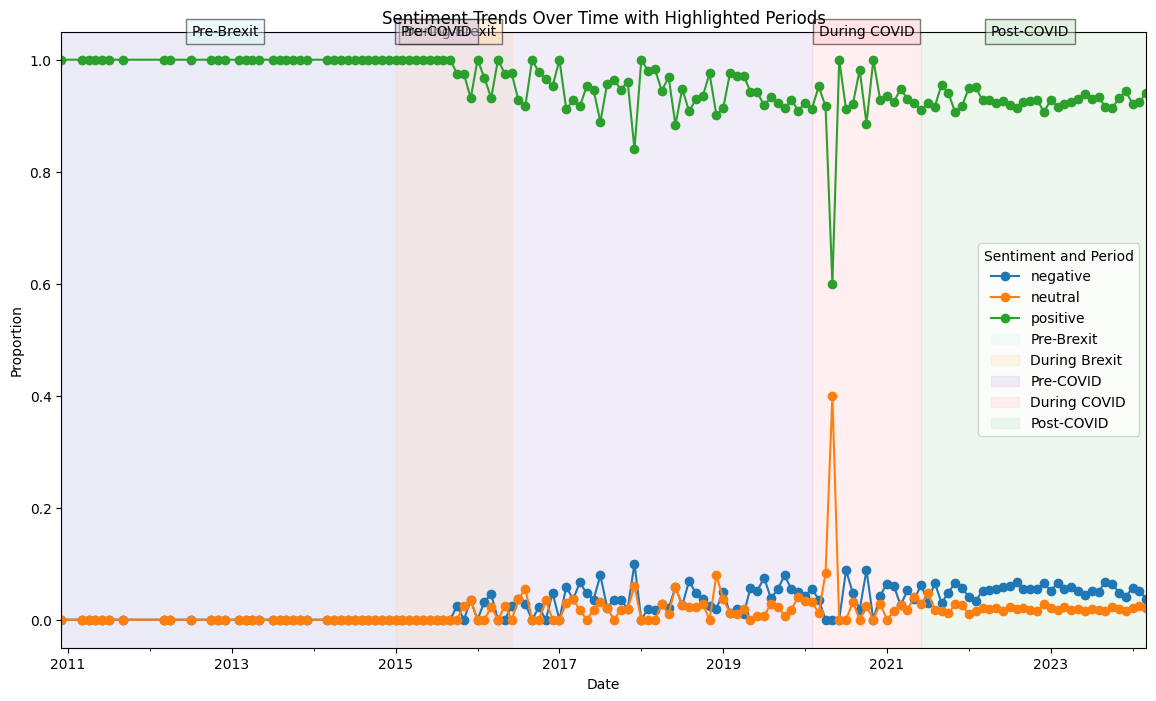

In [7]:
# Define periods of interest
periods = {
    "Pre-Brexit": (reviews_df['date'].min(), '2015-01'),
    "During Brexit": ('2015-01', '2016-06'),
    "Pre-COVID": (reviews_df['date'].min(), '2020-02'),
    "During COVID": ('2020-02', '2021-06'),
    "Post-COVID": ('2021-06', reviews_df['date'].max())
}

# Plot sentiment trends over time with highlighted periods
plt.figure(figsize=(14, 8))
sentiment_proportions.plot(kind='line', marker='o', ax=plt.gca())

# Highlight specific periods with distinct colors and add annotations
colors = ['#e0f7fa', '#ffe0b2', '#d1c4e9', '#ffcdd2', '#c8e6c9']
for i, (period, (start, end)) in enumerate(periods.items()):
    plt.axvspan(start, end, color=colors[i], alpha=0.3, label=period)
    plt.text(pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start)) / 2, 1.05, period,
             horizontalalignment='center', verticalalignment='center', fontsize=10, bbox=dict(facecolor=colors[i], alpha=0.5))

plt.title('Sentiment Trends Over Time with Highlighted Periods')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.legend(title='Sentiment and Period')
plt.show()